
=== Canopy Density: 0.015 trees/m² (150 stems/ha, n=201) ===
VV - Very Small: r=0.072, p=0.5312
VV - Small: r=0.316, p=0.0030
VV - Medium: r=0.357, p=0.0737
VV - Large: r=0.548, p=0.1270
HH - Very Small: r=-0.260, p=0.0206
HH - Small: r=-0.030, p=0.7835
HH - Medium: r=-0.218, p=0.2841
HH - Large: r=0.247, p=0.5220
VH - Very Small: r=-0.001, p=0.9935
VH - Small: r=0.222, p=0.0402
VH - Medium: r=0.333, p=0.0961
VH - Large: r=0.686, p=0.0414

=== Canopy Density: 0.06 trees/m² (600 stems/ha, n=201) ===
VV - Very Small: r=0.017, p=0.8842
VV - Small: r=0.304, p=0.0044
VV - Medium: r=0.356, p=0.0743
VV - Large: r=0.638, p=0.0647
HH - Very Small: r=-0.428, p=0.0001
HH - Small: r=-0.026, p=0.8130
HH - Medium: r=-0.186, p=0.3619
HH - Large: r=0.382, p=0.3099
VH - Very Small: r=-0.074, p=0.5163
VH - Small: r=0.291, p=0.0066
VH - Medium: r=0.390, p=0.0489
VH - Large: r=0.738, p=0.0231

=== Canopy Density: 0.24 trees/m² (2400 stems/ha, n=201) ===
VV - Very Small: r=0.012, p=0.9194
VV - Small: r=0.

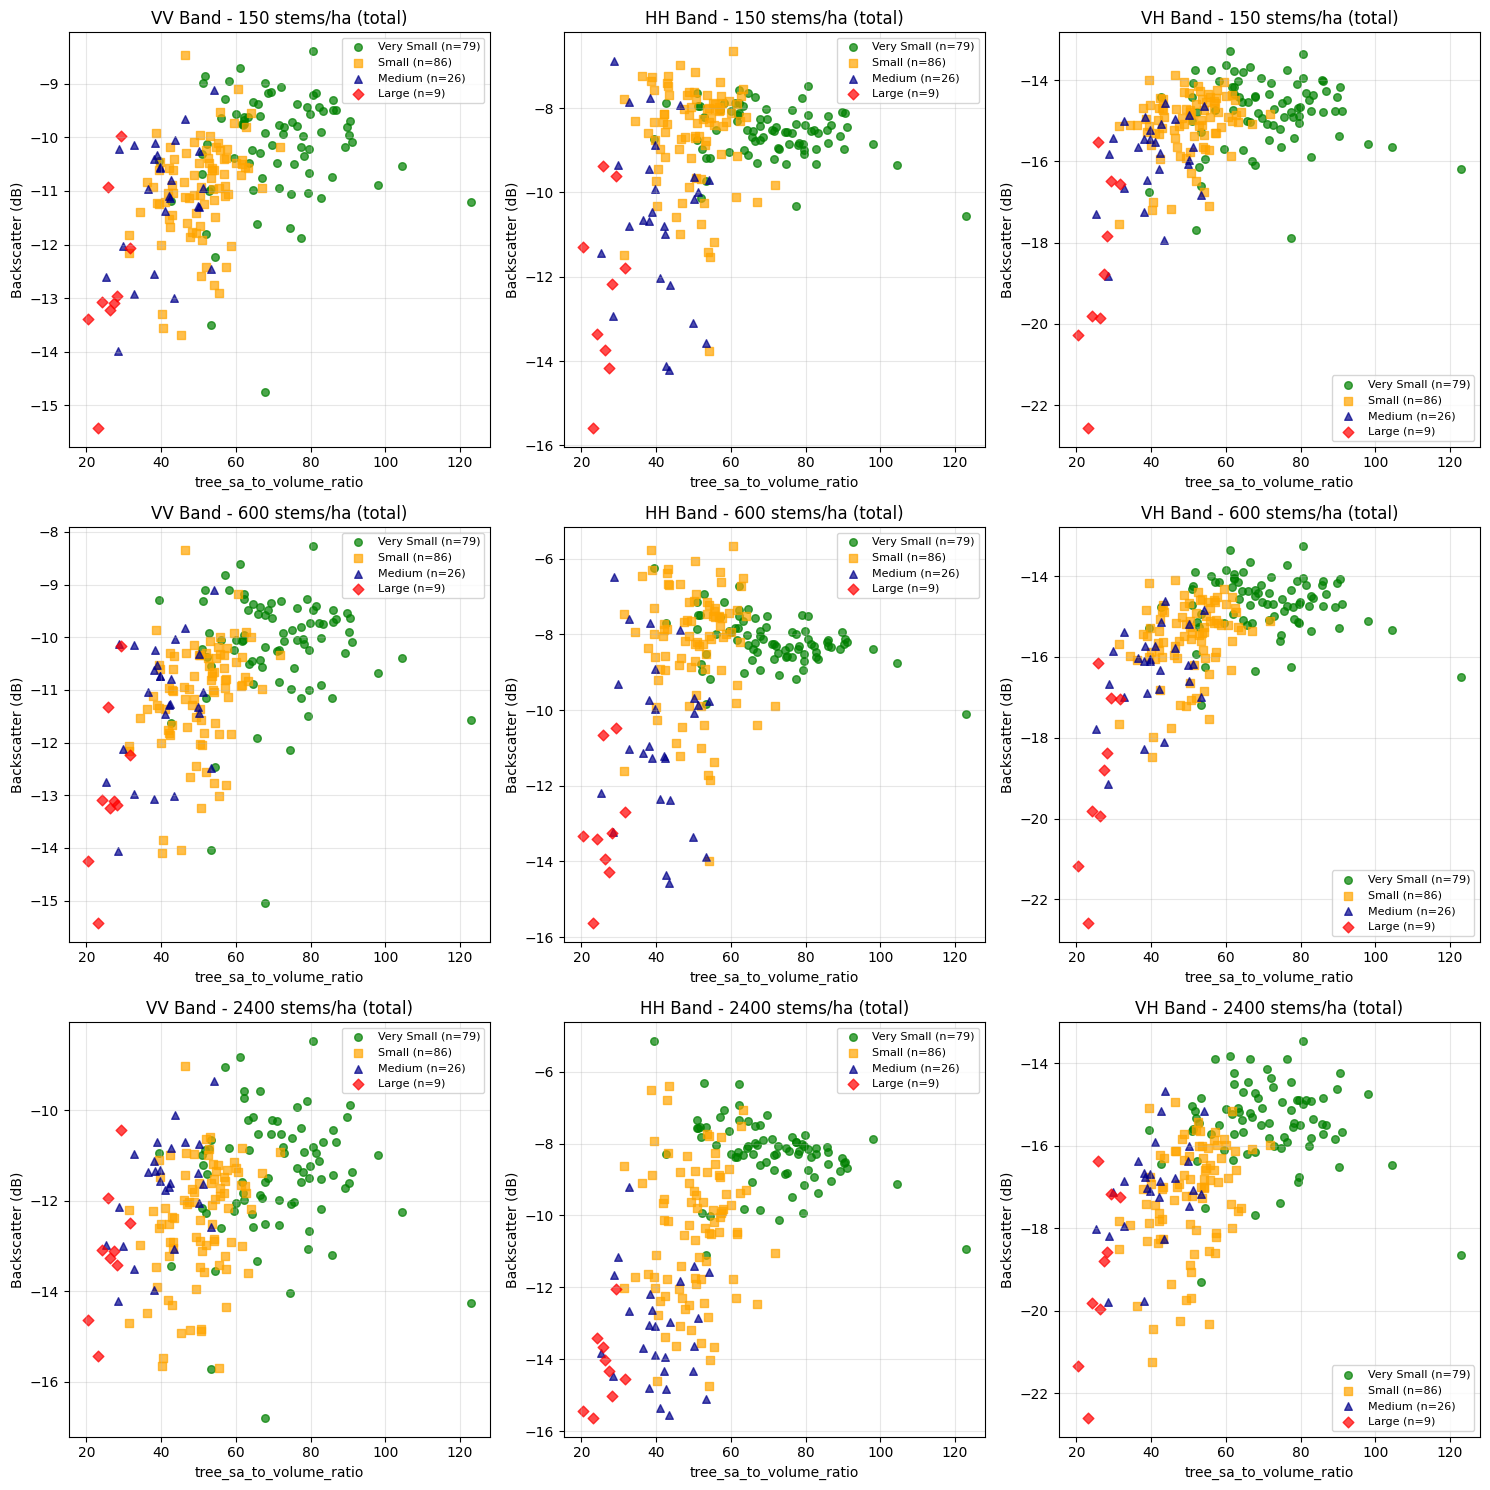

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_sa_ratio(csv_file, x_param='tree_sa_to_volume_ratio', backscatter_type='total', 
                     frequency=0.43, angle=30, soil_moisture=0.5, canopy_densities=[0.015]):
    """Analyze surface area to volume ratio vs backscatter by tree size across canopy densities"""
    df = pd.read_csv(csv_file)
    
    # Filter by frequency, angle, and soil moisture
    df = df[(df['frequency'] == frequency) & 
            (df['theta'] == angle) & 
            (df['soil_moisture'] == soil_moisture)]
    
    # Define backscatter columns based on type
    vv_col = f'{backscatter_type}_vv'
    hh_col = f'{backscatter_type}_hh'
    vh_col = f'{backscatter_type}_vh'
    
    # Clean data - avoid duplicate columns
    cols = ['total_tree_volume', 'canopy_density', vv_col, hh_col, vh_col]
    if x_param not in cols:
        cols.insert(1, x_param)
    df = df[cols].dropna()
    df = df[(df['total_tree_volume'] > 0) & (df[x_param] > 0)]
    
    # Define volume subgroups
    subgroups = {
        'Very Small': (0.05, 0.2),
        'Small': (0.2, 0.8),
        'Medium': (0.8, 2.5),
        'Large': (2.5, float('inf'))
    }
    
    # Create plot with rows for each canopy density
    n_densities = len(canopy_densities)
    fig, axes = plt.subplots(n_densities, 3, figsize=(15, 5*n_densities))
    
    # Ensure axes is 2D even with single density
    if n_densities == 1:
        axes = axes.reshape(1, -1)
    
    bands = [(vv_col, 'VV'), (hh_col, 'HH'), (vh_col, 'VH')]
    colors = ['green', 'orange', 'darkblue', 'red']
    markers = ['o', 's', '^', 'D']
    
    # Loop through each canopy density
    for row_idx, density in enumerate(canopy_densities):
        # trees/m² to stems/hectare 
        stems_per_ha = density * 10000
        
        # Filter for this canopy density
        df_density = df[df['canopy_density'] == density]
        
        print(f"\n=== Canopy Density: {density} trees/m² ({stems_per_ha:.0f} stems/ha, n={len(df_density)}) ===")
        
        # Loop through each band (VV, HH, VH)
        for col_idx, (band_col, band_name) in enumerate(bands):
            ax = axes[row_idx, col_idx]
            
            # Loop through size subgroups
            for idx, (name, (vmin, vmax)) in enumerate(subgroups.items()):
                # Filter subgroup
                if vmax == float('inf'):
                    sub_df = df_density[df_density['total_tree_volume'] >= vmin]
                else:
                    sub_df = df_density[(df_density['total_tree_volume'] >= vmin) & 
                                       (df_density['total_tree_volume'] < vmax)]
                
                if len(sub_df) > 5:
                    # Plot
                    ax.scatter(sub_df[x_param], sub_df[band_col],
                              c=colors[idx], marker=markers[idx], alpha=0.7, s=30,
                              label=f'{name} (n={len(sub_df)})')
                    
                    # Calculate correlation
                    r, p = pearsonr(sub_df[x_param], sub_df[band_col])
                    print(f"{band_name} - {name}: r={r:.3f}, p={p:.4f}")
            
            ax.set_xlabel(x_param)
            ax.set_ylabel('Backscatter (dB)')
            ax.set_title(f'{band_name} Band - {stems_per_ha:.0f} stems/ha ({backscatter_type})')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{x_param}_{backscatter_type}_analysis_{frequency}GHz_{angle}deg_multidens.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

csv_file = r"/home/ucfargt@ad.ucl.ac.uk/Documents/mimics/model_output.csv"

"""
    x_param = tree_sa_to_volume_ratio, trunk_to_tree_volume_ratio, canopy_to_tree_volume_ratio, total_canopy_volume, total_canopy_surface_area, trunk_volume, trunk_surface_area, total_tree_volume, total_tree_surface_area
    backscatter_type = [total, direct_crown, direct_ground, trunk_ground, gnd_crown_gnd, 
    frequency_values = [0.43]
    canopy_density_values = [0.015, 0.06, 0.24, 0.48, 0.72]
    soil_moisture_values = [0.25, 0.5, 0.75]  
"""

analyze_sa_ratio(csv_file, 
                x_param='tree_sa_to_volume_ratio', 
                backscatter_type='total', 
                frequency=0.43, 
                angle=30, 
                soil_moisture=0.5, 
                canopy_densities=[0.015, 0.06, 0.24])